<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>


<b>Student name:</b> Balthazar Neveu

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
!head -5 dict.txt

!pip install prettytable
!pip install sympy

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
path_vocab = Path("dict.txt")
assert path_vocab.exists()
pretraining_path_data_train = Path("pretraining_subset.txt")
assert pretraining_path_data_train.exists()

downstream_path_data_train = Path("train.review.spm")
assert downstream_path_data_train.exists()
downstream_path_labels_train = Path("train.label")
assert downstream_path_labels_train.exists()
downstream_path_data_valid = Path("test.review.spm")
assert downstream_path_data_valid.exists()
downstream_path_labels_valid = Path("test.label")
assert downstream_path_labels_valid.exists()

In [3]:
pretrained_model = Path("pretrained_model_4layers.pt")
assert pretrained_model.exists()

# Tensor convention for NLP
`[L, N, D]` : sentence first (`batch_first=False`)

- L sequence length
- N batch size
- V vocabulary dimension `ntokens`
- E embeddings dimension `embedding_dim`
- *D hidden dimension*
- *M transformer layers*
- *A number of heads in attention*

### Simplification:
- `E=D` hidden dimension set equal to th embedding dimension for simplicity in the following code `nhid = embedding_dim`



### The Model

In [4]:
class PositionalEncoding(nn.Module):
    """Add fixed precomputed positional encoding to the embeddings
    Add means (=literally addition)
    """
    def __init__(self, embdeddings_dim: int , dropout: float =0.1, max_len: int =5000):
        """Precompute a positional encoding vector of length `max_len`

        Args:
            embdeddings_dim (int): dimension of word embeddings. Note th
            dropout (float, optional): dropout ratio. Defaults to 0.1.
            max_len (int, optional): maximum sequence length. Defaults to 5000.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embdeddings_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embdeddings_dim, 2).float() * (-math.log(10000.0) / embdeddings_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """Add positional encoding to the word embeddings.
        Simply add the pre

        Args:
            x (torch.FloatTensor): embeddings tensor [L, N, D]

        Returns:
            torch.FloatTensor: Enhanced embeddings tensor, ready to go straight to the transformer blocks. 
        """
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

In [5]:
class TransformerModel(nn.Module):
    """Transformer base model 
    =========================
    - embedding from word to vectors
    - add positional encoding
    - `nlayers` * transformer blocks
    """
    def __init__(self, ntokens:int, nhead:int, nhid:int, nlayers:int, dropout=0.5):
        """Transformer base model

        Args:
            ntokens (int): the size of vocabulary
            nhead (int): number of heads in each of the MHA models
            nhid (int): hidden dimension of the model. assume `embedding_dim` = `nhid`
            nlayers (int): number of nn.TransformerEncoderLayer in nn.TransformerEncoder
            dropout (float, optional): dropout value. Defaults to 0.5.
        """
        super(TransformerModel, self).__init__()
        self.model_type = "Transformer"
        embedding_dim = nhid # use the same embedding & hidden dimensions
        self.encoder = nn.Embedding(ntokens, embedding_dim) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout=dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=nhid, # input dimension to the transformer encoder layer
            nhead=nhead, # number of heads for MHA (Multi-head attention)
            dim_feedforward=nhid, # output dimension of the MLP on top of the transformer.
            dropout=dropout
        ) # we assume nhid = d_model = dim_feedforward
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=nlayers
        )
        self.nhid = nhid
        self.init_weights()
    
    @staticmethod
    def generate_square_subsequent_mask(sz: int) -> torch.FloatTensor:
        """Generate causality mask = mask future tokens for next word prediction

        Args:
            sz (int): mask size M

        Returns:
            torch.FloatTensor: squares matrix [M, M] to mask the attention matrix.
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(
            self, src: torch.LongTensor,
            src_mask: torch.FloatTensor
        ) -> torch.FloatTensor:
        """Embdeddings, positional encoders, go trough `nlayers` of residual {multi (`nhead`) attention heads + MLP}.

        Args:
            src (torch.LongTensor): [L, N, V] sequence of tokens , V=vocabu
            src_mask (torch.FloatTensor): [L, L] squared mask

        Returns:
            torch.FloatTensor: encoded sequence [L, N, D]
        """
        src = self.encoder(src) * math.sqrt(self.nhid) #embed [L, N, V] -> [L, N, E]
        src = self.pos_encoder(src) # [L, N, E]  - add positional encoding
        output = self.transformer_encoder(src, mask=src_mask)
        return output

In [6]:
class ClassificationHead(nn.Module):
    def __init__(self, nhid: int, nclasses: int):
        """Linear classification head -> returns logits (not probabilities)

        Args:
            nhid (int): hidden dimension
            nclasses (int): number of classes.
        """
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.FloatTensor) -> torch.FloatTensor:
        """Classify encoded feature vectors

        Args:
            src (torch.FloatTensor): Encoded feature vectors [L, N, D]

        Returns:
            torch.FloatTensor: Logits (no softmax applied)
        """
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken: int, nhead: int, nhid: int, nlayers: int, nclasses: int, dropout: float=0.5):
        """TransformerModel+ClassificationHead
        
        This allows defining a model for next word prediction (classification with ntoken classes)
        Or other downstream tasks if the base `TransformerModel` is pretrained

        Args:
            ntoken (int): size of vocabulary for (`TransformerModel`)
            nhead (int): number of heads in each of the MHA models (`TransformerModel`)
            nhid (int): hidden dimension of the model. assume `embedding_dim` = `nhid`
            nlayers (int):  number of nn.TransformerEncoderLayer in nn.TransformerEncoder (`TransformerModel`)
            nclasses (int): number of output classes in the classifier `ClassificationHead`.
                - `nclasses` = size of vocabulary for next word prediction.
                - `nclasses` =2 for downstream tasks like sentiment analyzis.
            dropout (float, optional): dropout rate. Defaults to 0.5.  (`TransformerModel`)
        """
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout=dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src:torch.LongTensor, src_mask: torch.FloatTensor) -> torch.FloatTensor:
        """Encoder + linear classifier

        Args:
            src (torch.LongTensor): sequence of tokens [L, N, V]
            src_mask (torch.FloatTensor): [L, L] squared mask.

        Returns:
            torch.FloatTensor: [N, C]
        """
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

### Causal attention mask & useless computations (question 1)

In [7]:
sentence_length_test = 5
src_mask = TransformerModel.generate_square_subsequent_mask(sentence_length_test)
useless_computations = sentence_length_test*(sentence_length_test-1)//2
assert int( ((-src_mask).isinf()).sum()) == useless_computations
print(f"{useless_computations} useless computations for a sequence of {sentence_length_test} tokens")
src_mask

10 useless computations for a sequence of 5 tokens


tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

# Unit test

In [8]:
def test_transformer_based_classifier():
    ntokens = 100 #  V the size of vocabulary
    nhid = 200  # hidden dimension
    nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead = 2  # the number of heads in the multiheadattention models
    dropout = 0  # the dropout value
    nclasses = ntokens # classification to get output words in the same language
    model = Model(ntokens, nhead, nhid, nlayers, nclasses, dropout).to(device)
    dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21], [8, 5, 3, 42, 43, 21]]).to(device)

    sequence_length = dummy_input.shape[0] #L
    batch_size = dummy_input.shape[1] #N

    src_mask = TransformerModel.generate_square_subsequent_mask(sequence_length).to(device)
    assert list(src_mask.shape) == [sequence_length,sequence_length]
    # batch dimension N is not involved in the mask computation! We assume all sequences in the batch has the same sequence length L
    out = model.forward(dummy_input, src_mask)
    expected_size = [sequence_length, batch_size, nclasses]
    assert list(out.shape) == expected_size, f"{out.shape}, {expected_size}"
    print(out.shape)
test_transformer_based_classifier()

/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:255: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  encoder_layer.self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([2, 6, 100])


## Vocabulary and Tokenization

In [9]:
SRC = "source_sequence"
TGT = "target"
SOS = "<sos>"
PAD = "<pad>"
EOS = "<eos>"
OOV = "<oov>"
LM_TASK = "language_modeling"
DS_TASK = "classification"
token2ind = {SOS: 0, PAD : 1, EOS: 2, OOV: 3} # the 4 first indices are reserved to special tokens
offset = max(token2ind.values())+1
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx+offset
ind2token = {index: token for token, index in token2ind.items()}
print(ind2token[1111])

▁trop


### Data Loader


In [10]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from typing import Dict, List, Tuple

class Dataset(Dataset):
    def __init__(
        self,
        path_documents: Path,
        path_labels: Path = None,
        token2ind: Dict[str, int]={},
        max_len: int=512,
        task: str=LM_TASK,
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)
        self.oov_index = self.token2ind[OOV]
    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index: int):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1] 
        
        source_sequence = [self.token2ind.get(token, self.oov_index) for token in sequence]
        source_sequence.insert(0, self.token2ind[SOS]) 
        # (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == LM_TASK:
            target = source_sequence[1:] # offset the sequence by one
            # A, B , C, D , <EOS>
            target.append(self.token2ind[EOS])
            assert len(target) == len(source_sequence)
        elif self.task == DS_TASK:
            target = [self.labels[index]]
        sample = {
            SRC: torch.tensor(source_sequence),
            TGT: torch.tensor(target),
        }
        return sample


def collate_sentences_keep_dim(batch: List[Dict[str, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Uniformize batches (have the same sentence length with padding for all sentences across the batch)

    Args:
        batch (List[Dict[str, torch.LongTensor]]): List of dict samples containing 

    Returns:
        Tuple[torch.LongTensor, torch.LongTensor]: 
            - source [L, N, V]
            where L is the maximum length along all sentences in the batch
            - target 
                - [L, N, V] for language modeling task
                - [N, C] for classification with C the number of classes
            
    """
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample[SRC] for sample in batch], padding_value=token2ind[PAD]
    )
    target = pad_sequence(
        [sample[TGT] for sample in batch], padding_value=token2ind[PAD]
    )
    return source_sequences, target


def collate_sentences(batch: List[Dict[str, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Uniformization of batches through padding + flatten target labels"""
    source_sequences, target = collate_sentences_keep_dim(batch)
    return source_sequences, target.reshape(-1)

def get_loader(
    path_documents :Path,
    path_labels: Path = None,
    token2ind : Dict[str, int]={},
    max_len: int =512,
    batch_size: int = 32,
    task: str=LM_TASK,
    collate_fn = collate_sentences,
    shuffle=True
) -> DataLoader:
    """Unified data loader for both Language modeling and classification task

    Args:
        path_documents (Path): Path to a text file (each sentence is on a different line)
        path_labels (Path, optional): Path to classification labels. 
            Defaults to None for language modeling
        token2ind (Dict[str, int], optional): Mapping (look up table) between tokens and integer indexes. Defaults to {}.
        max_len (int, optional): Maximum sentence length, Defaults to 512.
            Please note that you may miss the <SOS> token a lot if max_len is low 
        batch_size (int, optional): Batch size sampled every time.
            Be careful with the last sample of the batch but here `drop_last=True`.  Defaults to 32.
        task (str, optional): 
            Choice `LM_TASK`, `DS_TASK`. Defaults to LM_TASK.
        collate_fn (_type_, optional): Collate function describing how to pad. Defaults to collate_sentences.
        shuffle (bool, optional): shuffle inputs. usually disable for validation set. Defaults to True.

    Returns:
        DataLoader: Pytorch dataloader.
            - inputs = sentence, target = offset sentence for language modeling
            - inputs = sentence, target = label for classification task
    """
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=max_len,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## Sanity check on data loader and collate functions

In [11]:
N = 32
data_loader = get_loader(
    pretraining_path_data_train,
    token2ind=token2ind,
    batch_size=N,
    task=LM_TASK,
    collate_fn=collate_sentences_keep_dim
)
token2ind[OOV]
it = iter(data_loader)

def tensor_to_sentence(tensor_sentence):
        return " ".join([ind2token.get(el, "not found").replace("▁", "") for el in tensor_sentence.numpy() if el != token2ind[PAD]])

for u in range(5):
    sampled_batch = next(it)
    # first[0].shape, first[1].shape
    # first[0][:, 0] # first sentence # L, N
    first_sentence = sampled_batch[0][:, 0]
    def tensor_to_sentence(tensor_sentence):
        return " ".join([ind2token.get(el, "not found").replace("▁", "") for el in tensor_sentence.numpy() if el != token2ind[PAD]])
    print(tensor_to_sentence(first_sentence))
    print(tensor_to_sentence(sampled_batch[1][:, 0]))

<sos> Il a aussi effectué d ' importants travaux pros op ographiques sur l ' époque ant on ine , et en particulier sur les vies de l ' Histoire Auguste .
Il a aussi effectué d ' importants travaux pros op ographiques sur l ' époque ant on ine , et en particulier sur les vies de l ' Histoire Auguste . <eos>
<sos> Les commissions locales de contrôle de la discipline du Parti aux divers échelons , y compris celles de l ' échelon de base , doivent en même temps en faire rapport aux commissions de contrôle de la discipline à l ' échelon directement supérieur .
Les commissions locales de contrôle de la discipline du Parti aux divers échelons , y compris celles de l ' échelon de base , doivent en même temps en faire rapport aux commissions de contrôle de la discipline à l ' échelon directement supérieur . <eos>
<sos> L ' espoir est aujourd ' hui revenu de parvenir à une conclusion favorable du programme de Doha à la Conférence de Hong - K ong en 2005.
L ' espoir est aujourd ' hui revenu de pa

# Model definition

In [21]:
ntokens = len(ind2token) # the size of vocabulary
print(f"TOTAL TOKENS {len(ind2token)}")
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model_pretraining = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

TOTAL TOKENS 50001


/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:255: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  encoder_layer.self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Question 3: Parameters amount analytic validation

In [14]:
from sympy import symbols, Eq, sympify
from IPython.display import display, Markdown
import sympy
from prettytable import PrettyTable

def count_parameters(my_model, table_flag=True, details=[]):
    table = PrettyTable(["Modules", "Parameters", "Analytic validation", "Analytic formula"])
    total_params = 0
    for index, (name, parameter) in enumerate(my_model.named_parameters()):
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        detail = ["", ""] if index>=len(details) else details[index]
        table.add_row([name, params, detail[0], detail[1]])
        total_params += params
    if table_flag:
        print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params



V, D, A, C, M = symbols("V, D, A, C, M") #(nhid*ntokens)
embedding_size = V*D
true_values = {
    M: int(nlayers),
    V: int(ntokens),
    D: int(nhid),
    A: int(nhead),
    C: int(ntokens)
}
list_computations = []
def get_analytic_expression(name, expr_:str):
    expr = sympify(expr_)
    res = expr.evalf(subs=true_values)
    equation = Eq(expr, int(res))
    latex_eq = sympy.latex(equation)
    eq_original  = sympy.latex(sympify(expr_, evaluate=False))
    display(Markdown(f"{name}: ${eq_original}$ =  $ {latex_eq} $"))
    list_computations.append([int(res) , str(expr).replace("**2", "²")]) #[f"{name}: ${eq_original}$ =  $ {latex_eq} $", ])
get_analytic_expression("Embeddings linear projection weights", "V*D")
get_analytic_expression("MHA inputs Weights (Key, Query, Value)", "A*3*(D*(D/A))")
get_analytic_expression("MHA inputs Bias (Key, Query, Value)", "A*3*(D/A)")

get_analytic_expression("MHA output Weights", "A*((D/A)*D)")
get_analytic_expression("MHA output Bias", "A*(D/A)")

for linear_layer in range(1, 2+1):
    get_analytic_expression(f"Position-wise #{linear_layer} Linear MLP weights", "D*D")
    get_analytic_expression(f"Position-wise #{linear_layer} Linear MLP bias", "D")

for linear_layer in range(1, 2+1):
    get_analytic_expression(f"Layer norm #{linear_layer} coefficient", "D")
    get_analytic_expression(f"Layer norm #{linear_layer} bias", "D")


get_analytic_expression("Classifier weights", "D*C")
get_analytic_expression("Classifier bias", "C")

# Layer Normalization applies per-element scale and bias... so to each D dimension
model_dissect = Model(ntokens, nhead, nhid, 1, ntokens, dropout).to(device)
count_parameters(model_dissect, table_flag=True, details=list_computations)

print(20*"⚠️ " + "Simplified M=1 layer model")

Embeddings linear projection weights: $D V$ =  $ D V = 10000200 $

MHA inputs Weights (Key, Query, Value): $A 3 D D \frac{1}{A}$ =  $ 3 D^{2} = 120000 $

MHA inputs Bias (Key, Query, Value): $A 3 D \frac{1}{A}$ =  $ 3 D = 600 $

MHA output Weights: $\frac{A D D}{A}$ =  $ D^{2} = 40000 $

MHA output Bias: $\frac{A D}{A}$ =  $ D = 200 $

Position-wise #1 Linear MLP weights: $D D$ =  $ D^{2} = 40000 $

Position-wise #1 Linear MLP bias: $D$ =  $ D = 200 $

Position-wise #2 Linear MLP weights: $D D$ =  $ D^{2} = 40000 $

Position-wise #2 Linear MLP bias: $D$ =  $ D = 200 $

Layer norm #1 coefficient: $D$ =  $ D = 200 $

Layer norm #1 bias: $D$ =  $ D = 200 $

Layer norm #2 coefficient: $D$ =  $ D = 200 $

Layer norm #2 bias: $D$ =  $ D = 200 $

Classifier weights: $C D$ =  $ C D = 10000200 $

Classifier bias: $C$ =  $ C = 50001 $

/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:255: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  encoder_layer.self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


+-------------------------------------------------------------+------------+---------------------+------------------+
|                           Modules                           | Parameters | Analytic validation | Analytic formula |
+-------------------------------------------------------------+------------+---------------------+------------------+
|                     base.encoder.weight                     |  10000200  |       10000200      |       D*V        |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |   120000   |        120000       |       3*D²       |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |    600     |         600         |       3*D        |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |   40000    |        40000        |        D²        |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |    200     |         200         |        D         |
|       base.transformer_encoder.layers.0.linear1.weight

In [15]:
model_dissect = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
total = count_parameters(model_dissect, table_flag=False, details=[])
get_analytic_expression("Matches - Full model", "V*D + M*(6*(D^2+D) + 4*D) + C*(D+1)")


get_analytic_expression("Classification model - frozen transformer backbone", "2*(D+1)")

Total Trainable Params: 21018401


Matches - Full model: $C \left(D + 1\right) + D V + M \left(4 D + 6 \left(D^{2} + D\right)\right)$ =  $ C \left(D + 1\right) + D V + M \left(6 D^{2} + 10 D\right) = 21018401 $

Classification model - frozen transformer backbone: $2 \left(D + 1\right)$ =  $ 2 D + 2 = 402 $

## Training loop

In [22]:
# optimization parameters
criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model_pretraining.parameters(), lr=lr)

In [23]:
def train(
    model: Model,
    path_data_train: Path,
    path_labels_train: Path =None,
    path_data_valid: Path = None,
    save_interval: int =-1,
    log_interval: int=5,
    task: str=LM_TASK,
    batch_size: int =32,
    max_len=512,
    epoch=0,
    name="",
    freeze_backbone=False
):
    model.train()
    if freeze_backbone:
        print("FREEZE TRANSFORMER BACKBONE")
        for param in model.base.parameters():
            param.requires_grad = False
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        max_len=max_len,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): # get a batch of samples
        # reset gradients to zero
        optimizer.zero_grad()
        
        src_mask = TransformerModel.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        # forward pass
        output = model(input, src_mask) 
        if task == DS_TASK:
            output = output[-1:, :]  # last vector only
        output = output.view(-1, output.shape[-1])
        target = data[1]
        target = target.to(device)
        loss =  criterion(output, target) # CROSS ENTROPY
        loss.backward() # compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                f"| epoch {epoch:3d} | {idx:5d}/{len(data_loader):5d} steps | "+
                f"loss {cur_loss:5.5f} | ppl {math.exp(cur_loss):8.3f}"
            )
            losses.append(cur_loss)
            total_loss = 0
    if epoch % save_interval == 0 and save_interval>=1:
        torch.save(model, f"weights_{task}{name}_{epoch:02d}.pt")
    return losses

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()
# EMPTY THE GPU

In [26]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        model_pretraining,
        pretraining_path_data_train,
        save_interval=-1,
        task=LM_TASK,
        batch_size=16,
        max_len=64,
        log_interval=log_interval,
        epoch=epoch
    )

KeyboardInterrupt: 

## Text Generation


In [28]:
model_pretrained = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model_pretrained.load_state_dict(checkpoint['model_state_dict'])

/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:255: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  encoder_layer.self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [29]:
import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [30]:
def infer_next_token(sent, model):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind =  int(torch.argmax(torch.nn.Softmax(dim=-1)(out[-1, 0, :])).detach()) #FORCE N=1
    return next_token_ind, out

def infer_next_tokens(sent, model, max_len=50):
    next_token_list = []
    next_token_index=-1
    iter = 0
    while next_token_index!=token2ind[EOS]:
        if iter>max_len:
            break
        next_token_index, out = infer_next_token(sent, model)
        next_token = ind2token.get(next_token_index)
        sent+= next_token
        next_token_list.append(next_token)
    return next_token_list


sent = "Bonjour les"
out = infer_next_tokens(sent, model_pretrained)
print(sent + " " + s.decode_pieces(out[:-1]))

Bonjour les gens qui ont été très accueillants et sympathiques.


### Supervised task

In [31]:
data_loader_validation = get_loader(
    downstream_path_data_valid,
    downstream_path_labels_valid,
    token2ind=token2ind,
    # batch_size=20,
    batch_size=1, # Let's use a batch size of 1 so a sentence always has maximum length
    task='classification',
    shuffle=False # AVOID SHUFFLING FOR OBVIOUS REASONS - even if we're going through the whole validation set - let's do it in the same order everytime (batches will always be the same, no matter the configuration)
)
print(f"{len(data_loader_validation.dataset)} sentences in the validation set")

2000 sentences in the validation set


In [32]:
for idx, sentence_batch in enumerate(data_loader_validation):
    if idx>10:
        break
    first_sentence = sentence_batch[0][:, 0]
    print(tensor_to_sentence(first_sentence))
    print(bool(sentence_batch[1][0]))

<sos> J ' ai lu ce livre car dans ma ville , tout le monde s ' en sert et le commande . C ' est ma pharmaci enne qui me l ' a conseillé , elle a t ellement maig ri que je lui ai demandé ce qu ' elle avait fait et au lieu de me vendre du per li mp in pin en gé lules , elle m ' a conseillé ce livre à 5 euros . Bien sur , il faut faire un effort pour perdre 25 kilos mais avec le livre , j ' avais un compagnon de route . L ' auteur a su me parler simplement avec des arguments très forts et surtout j ' ai senti qu ' il connaissait bien des cas comme le mien . Il y a dans son texte de l ' expérience , de la simplicité et de la compassion pour ceux qui comme moi vivait avec tout ce poids qui me col lait au corps sans jamais vouloir partir . Je ne crois pas qu ' il existe un régime miracle qui surp asse les autres mais je crois vraiment qu ' il y a des personnes qui savent parler aux autres et faire n aitre des déclic s . Je croyais être faible mais ce livre m ' a rendu forte , je l ' ai t ell

In [54]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader: DataLoader, model):
    accuracy = 0
    for _idx, sentence_batch in enumerate(data_loader):
        input_sentences = sentence_batch[0].to(device)
        target_labels = sentence_batch[1].to(device)
        logits = model(input_sentences, src_mask=None)
        logits = logits[-1, ...]
        predicted_class = torch.argmax(logits, dim=-1)
        accuracy += torch.sum(predicted_class==target_labels).detach()
    accuracy = float(accuracy)/len(data_loader.dataset)
    return accuracy

def test_evaluate_accuracy():
    # FAKE DOWNSTREAM MODEL ~ accuracy shall be around 0.5
    model_ds = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    model_ds.eval()

    data_loader_validation_ds = get_loader(
        downstream_path_data_valid,
        downstream_path_labels_valid,
        token2ind=token2ind,
        batch_size=20, # Let's use a batch size of 1 so a sentence always has maximum length
        task=DS_TASK,
        shuffle=False # AVOID SHUFFLING FOR OBVIOUS REASONS - even if we're going through the whole validation set - let's do it in the same order everytime (batches will always be the same, no matter the configuration)
    )
    acc = evaluate_accuracy(
        data_loader_validation_ds,
        model_ds
    )

    
    print(f"accuracy of a randomly initalized classifier {acc} ~ shall be around 0.5")

test_evaluate_accuracy()

accuracy of a randomly initalized classifier 0.493 ~ shall be around 0.5


In [55]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model_pretrained.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [ ]:
metrics = {}

In [95]:
training_configs = {
    "from scratch": [True, False, 0.0001],
    "pretrained trainable backbone": [False, False, 0.0001],
    "pretrained frozen backbone": [False, True, 0.001]
}

training_configs = {
    "pretrained frozen backbone LR 1E-4": [False, True, 0.0001]
}

TRAIN = "training"
VALID = "validation"


batch_size_eval = 20
train_dl = get_loader(
    downstream_path_data_train,
    downstream_path_labels_train,
    token2ind=token2ind,
    batch_size=batch_size_eval,
    task=DS_TASK,
    shuffle=False # AVOID SHUFFLING FOR OBVIOUS REASONS - even if we're going through the whole validation set - let's do it in the same order everytime (batches will always be the same, no matter the configuration)
)
valid_dl = get_loader(
    downstream_path_data_valid,
    downstream_path_labels_valid,
    token2ind=token2ind,
    batch_size=batch_size_eval,
    task=DS_TASK,
    shuffle=False
)

epochs = 15
for config, config_vals in training_configs.items():
    from_scratch, frozen, lr = config_vals
    metrics[config] = {
        TRAIN:[],
        VALID:[]
    }
    model_ds = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_ds.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model_ds.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    
    # @TODO: check batch size subtlety on the last element (we want to classify the last feature of the sentence!)
    for epoch in range(1, epochs + 1):
        model_ds.train()
        train(
            model_ds,
            downstream_path_data_train,
            downstream_path_labels_train,
            save_interval=-1,
            task=DS_TASK,
            freeze_backbone=frozen,
            batch_size=8,
            # batch_size=1, # TO AVOID THE NEED TO RETRIEVE THE RIGHT LAST TOKEN IN A BATCH
            log_interval=50,
            epoch=epoch,
            name="_from_scratch" if from_scratch else "_pretrained"
        )
        model_ds.eval()
        acc_train = evaluate_accuracy(train_dl, model_ds)
        acc_valid = evaluate_accuracy(valid_dl, model_ds)
        
        metrics[config][TRAIN].append(acc_train)
        metrics[config][VALID].append(acc_valid)
        print(f"{from_scratch=} - ACCURACY TRAIN {acc_train} VALIDATION={acc_valid}")

/home/bneveu/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:255: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  encoder_layer.self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


=====PRETRAINED MODEL======
FREEZE TRANSFORMER BACKBONE
| epoch   1 |    50/  200 steps | loss 0.77176 | ppl    2.164
| epoch   1 |   100/  200 steps | loss 0.76692 | ppl    2.153
| epoch   1 |   150/  200 steps | loss 0.76183 | ppl    2.142
from_scratch=False - ACCURACY TRAIN 0.5025 VALIDATION=0.498
FREEZE TRANSFORMER BACKBONE
| epoch   2 |    50/  200 steps | loss 0.74183 | ppl    2.100
| epoch   2 |   100/  200 steps | loss 0.74681 | ppl    2.110
| epoch   2 |   150/  200 steps | loss 0.72612 | ppl    2.067
from_scratch=False - ACCURACY TRAIN 0.5075 VALIDATION=0.5055
FREEZE TRANSFORMER BACKBONE
| epoch   3 |    50/  200 steps | loss 0.72556 | ppl    2.066
| epoch   3 |   100/  200 steps | loss 0.69968 | ppl    2.013
| epoch   3 |   150/  200 steps | loss 0.69201 | ppl    1.998
from_scratch=False - ACCURACY TRAIN 0.528125 VALIDATION=0.5385
FREEZE TRANSFORMER BACKBONE
| epoch   4 |    50/  200 steps | loss 0.71209 | ppl    2.038
| epoch   4 |   100/  200 steps | loss 0.67809 | ppl    

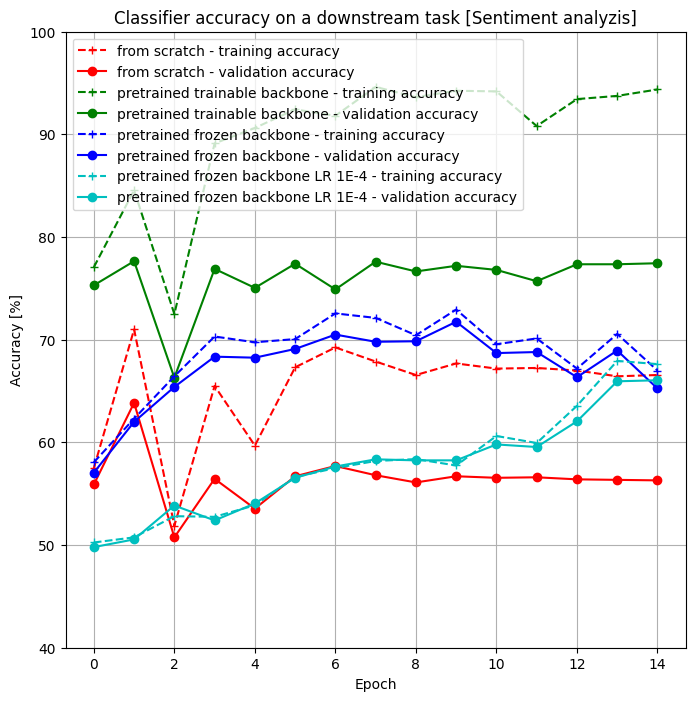

In [96]:
#Visualize the accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for idx, conf in enumerate(metrics.keys()):
    color = "rgbc"[idx]
    for mode in [TRAIN, VALID]:
        plt.plot(100.*np.array(metrics[conf][mode]), color+("--+" if mode==TRAIN else "-o"), label=f"{conf} - {mode} accuracy")
    # plt.plot(100.*np.array(pretrained_valid_acc), "-+b", label="pretrained model")
plt.grid()
plt.title("Classifier accuracy on a downstream task [Sentiment analyzis]")
plt.legend()
plt.ylim(40., 100)
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.show()

In [61]:
model_ds.eval()
acc = evaluate_accuracy(
    get_loader(
        downstream_path_data_valid,
        downstream_path_labels_valid,
        token2ind=token2ind,
        # batch_size=20,
        batch_size=1, # Let's use a batch size of 1 so a sentence always has maximum length
        task='classification',
        shuffle=False # AVOID SHUFFLING FOR OBVIOUS REASONS - even if we're going through the whole validation set - let's do it in the same order everytime (batches will always be the same, no matter the configuration)
    ),
    model_ds
)
acc


0.786

In [76]:

model_ds.eval()
acc_train = evaluate_accuracy(
    train_dl,
    model_ds
)
acc_valid = evaluate_accuracy(
    valid_dl,
    model_ds
)
acc_train, acc_valid

(0.590625, 0.5295)

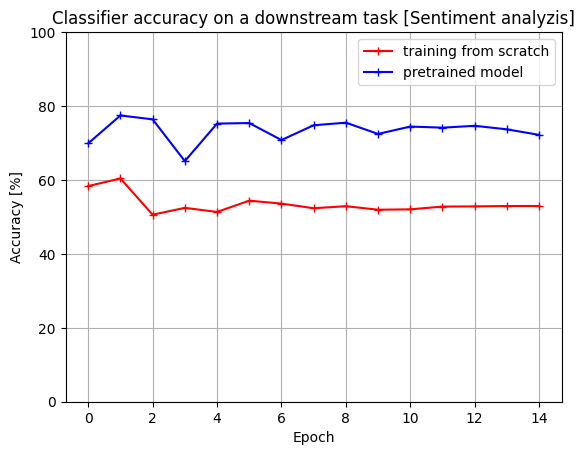

In [68]:
#Visualize the accuracy
import matplotlib.pyplot as plt
plt.plot(100.*np.array(from_scratch_valid_acc), "-+r", label="training from scratch")
plt.plot(100.*np.array(pretrained_valid_acc), "-+b", label="pretrained model")
plt.grid()
plt.title("Classifier accuracy on a downstream task [Sentiment analyzis]")
plt.legend()
plt.ylim(0, 100)
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.show()